In [52]:
import pandas as pd
import numpy as np
import random

%matplotlib inline
import matplotlib.pyplot as plt

# Bayesian Inference - Application to Data Analysis

- Using Bayesian inference to determine the probability that a job posting with screener questions on a job board gets a contact after a certain number of days on the board.

- This can be applied to different <i>product optimization</i> contexts.
- Apply hypothesis tests later to confirm hypotheses

<b>Notes</b>:

For simplicity, random numbers are generated uniformly or set to different probabilities initially.

In [301]:
%%html
<hr>

## 1. Generate Data

<b>Data description</b>

- jobhash: unique job posting identifier

- contact_boolean: labels a job posting if there was at least one contact from the advertiser to applicant

- screener_boolean: labels a job if it contains screener questions

- post_to_contact_days: number of days from a job's posting to first contact date

In [397]:
# job posting sample size
job_count = 1000000

# number of days for sample of contacts (0 to num_days)
num_days = 365

# fraction of jobs with a contact
contact_percent_set = 0.7

In [398]:
# generate a list of random job identifiers
jobhash_list = [random.randrange(1000,10000) for x in range(job_count)]


# generate booleans for jobs with contacts, jobs with screener questions
# artificially set 60% contacts
contact_boolean = [np.random.choice(np.arange(0, 2), p=[0.4,0.6]) for x in range(job_count)]
#[random.randint(0,1) for x in range(job_count)]

# uniform random distribution
screener_boolean = [random.randint(0,1) for x in range(job_count)]

# number of days from posting to contact for job postings
post_to_contact_days = [random.randint(0,365) for x in range(job_count)]

In [399]:
df_job_data = pd.DataFrame(zip(jobhash_list, contact_boolean, screener_boolean, post_to_contact_days),
                           columns=['jobhash', 'contact_boolean', 'screener_boolean', 'post_to_contact_days'])

df_job_data.head()

,jobhash,contact_boolean,screener_boolean,post_to_contact_days
0,5087,0,1,70
1,9052,1,1,262
2,9751,1,0,282
3,9089,0,0,302
4,4718,1,0,111


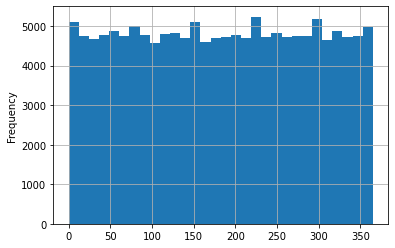

In [415]:
# some jobs may not have contacts so set a certain percentage (10) to nan
# this changes the original contact probability that we set earlier. 
# A combination effect of no_contact_percent_set and the contact_boolean list above

df_job_data['post_to_contact_days'] = df_job_data['post_to_contact_days'].sample(frac=contact_percent_set)

# set the contact_boolean accordingly
df_job_data.loc[df_job_data['post_to_contact_days'].isnull(), 'contact_boolean'] = 0
df_job_data.loc[df_job_data['contact_boolean']==0, 'post_to_contact_days'] = np.nan

df_job_data['post_to_contact_days'].plot(kind='hist', bins=30)
plt.grid()

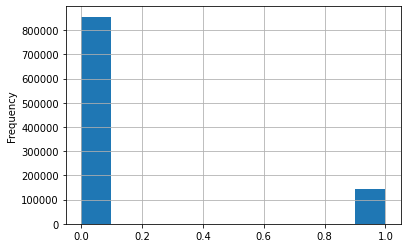

In [416]:
df_job_data['contact_boolean'].plot(kind='hist')
plt.grid()

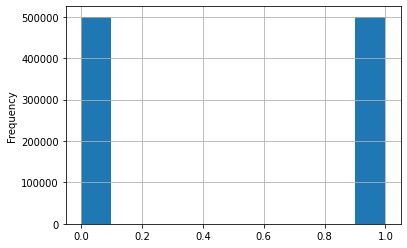

In [417]:
df_job_data['screener_boolean'].plot(kind='hist')
plt.grid()

In [302]:
%%html
<hr>

## 2. Probabilities

In [418]:
df_counts = df_job_data.pivot_table(index='contact_boolean', columns=['screener_boolean'],
                        values='jobhash', aggfunc='count', margins=True)

df_counts

screener_boolean,0,1,All
contact_boolean,,,
0,427302,428371,855673
1,72444,71883,144327
All,499746,500254,1000000


In [419]:
# reshape - better for later calculations
df_counts = df_counts.reset_index().rename_axis(None, axis=1)
df_counts.rename(columns={0:'no_screener', 1:'screener'}, inplace = True)

df_counts

,contact_boolean,no_screener,screener,All
0,0,427302,428371,855673
1,1,72444,71883,144327
2,All,499746,500254,1000000


### 2.1. Probability of a job posting getting at least 1 contact

<b>Note</b>: This number will be relevant later...

In [420]:
# probability of a job getting at least 1 contact

prob_contact = df_job_data[df_job_data['contact_boolean']==1].count()['contact_boolean']/df_job_data['jobhash'].count()

prob_contact

0.144327

### 2.2. Probability that a job posting has screener questions

<b>Note</b>: This number will also be relevant later...

In [421]:
prob_screener = df_job_data[df_job_data['screener_boolean']==1].count()['contact_boolean']/df_job_data['jobhash'].count()

prob_screener

0.500254

In [300]:
%%html
<hr>

## 3. Conditional Probabilities

What is the probability that a job has screener questions if it gets at least 1 contact on the second day after its posting?

In [450]:
# count of screener/no screener by post_to_contact_days

df_contacts_per_day = df_job_data.pivot_table(index='post_to_contact_days',
                        columns=['screener_boolean'],
                        values='jobhash',
                        aggfunc='count',
                        margins=True)

df_contacts_per_day = df_contacts_per_day.reset_index().rename_axis(None, axis=1)
df_contacts_per_day.rename(columns={0:'no_screener', 1:'screener'}, inplace = True)

In [451]:
df_contacts_per_day.head()

,post_to_contact_days,no_screener,screener,All
0,0.0,216,196,412
1,1.0,195,191,386
2,2.0,185,172,357
3,3.0,192,195,387
4,4.0,195,205,400


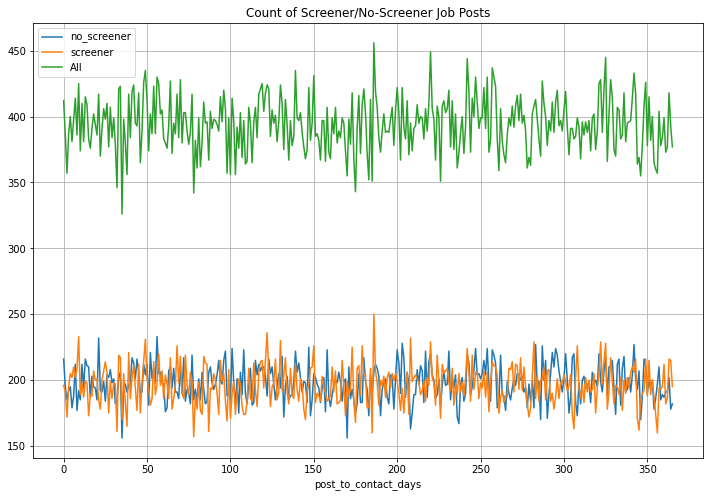

In [452]:
# count of job postings vs. post-to-contact days
df_contacts_per_day[df_contacts_per_day['post_to_contact_days']!='All'][:].plot(x='post_to_contact_days',
                                                                                title='Count of Screener/No-Screener Job Posts',
                                                                                figsize=(12,8))
plt.grid()

### 3.1. P(screener | contact_days=2) 
Probability of job posting having screener questions given that it has at least one contact on day 2

<b>Note</b>: 
The answer is 0.5 or close because the contact booleans are randomly and uniformly distributed.

In [453]:
df_contact_day_2 = df_contacts_per_day[df_contacts_per_day['post_to_contact_days']==2]

df_contact_day_2['screener']/df_contact_day_2['All']

2    0.481793
dtype: float64

### 3.2. P(no screener | contact_days=2) 
Probability of job posting having no screener questions given that it has at least one contact on day 2

<b>Note</b>: 
The answer is 0.5 or close because the contact booleans are randomly and uniformly distributed.

In [454]:
df_contact_day_2['no_screener']/df_contact_day_2['All']

2    0.518207
dtype: float64

### 3.3. Extend to Dataset

Notes:
Interesting observation that the conditional probabilities oscillate about 0.5.

In [455]:
df_contacts_per_day['screener_probability'] = df_contacts_per_day['screener']/df_contacts_per_day['All']
df_contacts_per_day['no_screener_probability'] = df_contacts_per_day['no_screener']/df_contacts_per_day['All']

In [456]:
df_contacts_per_day.head()

,post_to_contact_days,no_screener,screener,All,screener_probability,no_screener_probability
0,0.0,216,196,412,0.475728,0.524272
1,1.0,195,191,386,0.494819,0.505181
2,2.0,185,172,357,0.481793,0.518207
3,3.0,192,195,387,0.503876,0.496124
4,4.0,195,205,400,0.512500,0.487500


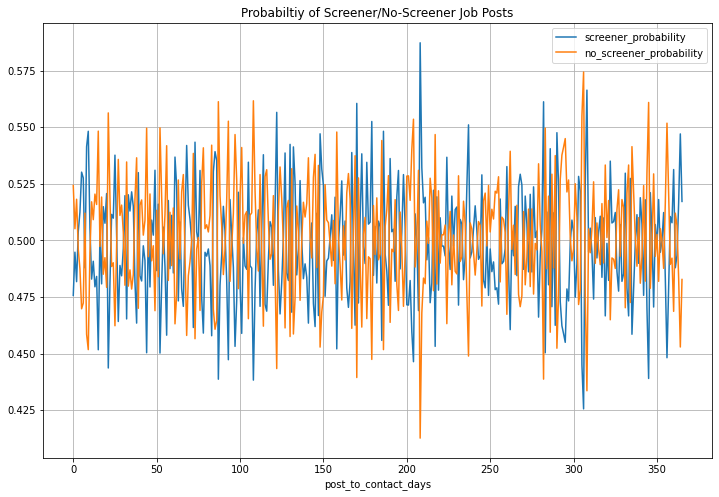

In [457]:
# probability of having screener questions or not given contact on x days after posting
y_plot_list = ['screener_probability', 'no_screener_probability']
df_contacts_per_day[df_contacts_per_day['post_to_contact_days']!='All'][:].plot(x='post_to_contact_days',
                                                                                y=y_plot_list,
                                                                                title='Probabiltiy of Screener/No-Screener Job Posts',
                                                                                figsize=(12,8))
plt.grid()

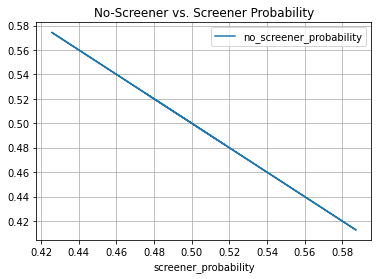

In [460]:
# visual check that P(no_screener) = 1 - P(screener)
df_contacts_per_day[df_contacts_per_day['post_to_contact_days']!='All'][:].plot(x='screener_probability',
                                                                                y='no_screener_probability',
                                                                                title= 'No-Screener vs. Screener Probability'
                                                                               )
plt.grid()

In [303]:
%%html
<hr>

## 4. Bayesian Inference

Given the data so far, we can calculate the probabilities of a job posting that has screener questions or not can have contacts x days after contact. 

i.e. P(screener|contact) or P(no_screener|contact)

However, for the sake of product optimization, we are more interested in a different conditional probability:

<br>

The <i>probabilities of a job post getting a contact x days after its initial posting given that it has screener question or not</i>:

P(contact|screener) or P(contact|no_screener)

Enters Bayes' Theorem...

<b> Bayes' Theorem </b>
    
$$ P(A|B) = \frac{P(B|A) * P(A)}{P(B)}$$

In our case:

$$ P(\text{contact}| \,\text{screener}) = \frac{P(\text{screener}|\text{contact}) * P(\text{contact})}{P(\text{screener})}$$

$$ P(\text{contact}|\text{no_screener}) = \frac{P(\text{no_screener}|\text{contact}) * P(\text{contact})}
{P(\text{no_screener})}$$

In [433]:
df_contacts_per_day.head()

,post_to_contact_days,no_screener,screener,All,screener_probability,no_screener_probability
0,0.0,216,196,412,0.475728,0.524272
1,1.0,195,191,386,0.494819,0.505181
2,2.0,185,172,357,0.481793,0.518207
3,3.0,192,195,387,0.503876,0.496124
4,4.0,195,205,400,0.512500,0.487500


In [440]:
# remember the screener probability derived earlier!
print(prob_screener, 1-prob_screener)

0.500254 0.499746


In [438]:
# probabilty contact derived earlier
prob_contact

0.144327

In [461]:
def contact_cond_prob(x, prob_contact, prob_screener):
    '''
        Returns converse conditional probability P(B|A)
            x: column for the original conditional probabity P(A|B)
            prob_contact: number; probability of contact
            prob_screener: number; probability of screener (needs to be adjusted for the no-screener case)
    '''
    return prob_contact * x / prob_screener



# Finally, calculate the probabilities of contacts given screener / no_screener

df_contacts_per_day['contact_given_screener'] = df_contacts_per_day.apply(lambda x: contact_cond_prob(x['screener_probability'], prob_contact, prob_screener), axis=1)

#note the use of 1-prob_screener in this calculation
df_contacts_per_day['contact_given_no_screener'] = df_contacts_per_day.apply(lambda x: contact_cond_prob(x['no_screener_probability'], prob_contact, 1-prob_screener), axis=1)

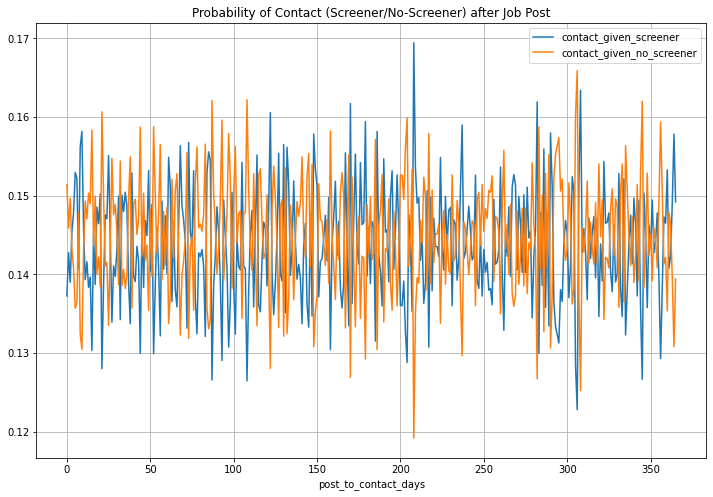

In [466]:
# and voila...probability of having screener questions or not given contact on x days after posting
y_plot_list = ['contact_given_screener', 'contact_given_no_screener']
df_contacts_per_day[df_contacts_per_day['post_to_contact_days']!='All'][:].plot(x='post_to_contact_days',
                                                                                y=y_plot_list,
                                                                                title='Probability of Contact (Screener/No-Screener) after Job Post',
                                                                                figsize=(12,8))
plt.grid()

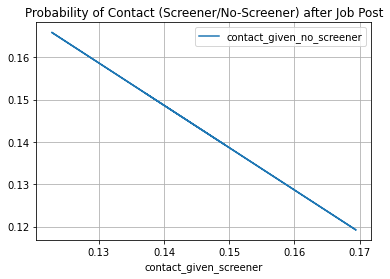

In [469]:
# Plot of P(contact|no-screener) vs P(contact|screener)
df_contacts_per_day[df_contacts_per_day['post_to_contact_days']!='All'][:].plot(x='contact_given_screener',
                                                                                y='contact_given_no_screener',
                                                                                title='Probability of Contact (Screener/No-Screener) after Job Post'
                                                                               )
plt.grid()